In [122]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from IPython.display import display, Audio
import os
import audio_utils
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
bg_dir = '../../LibriVox_Kaggle/BGnoise/'
rir_dir = '../../RIR/MIT_IR_Survey/Audio/'
bg_files = os.listdir(bg_dir)
rir_files = os.listdir(rir_dir)[1:]

csv_f = 'Librivox_fnames.csv'
csv_f0 = '../speechRemoval/fin_dataframe.csv'

df0 = pd.read_csv(csv_f0)
df = pd.read_csv(csv_f)

In [18]:
noise = audio_utils.add_two_noise([random.choice(df['aud_fname']), random.choice(df0['file1'])], [5])
feats = audio_utils.get_random_audioFeatures(noise)
feats.shape

torch.Size([1, 40, 251])

In [136]:
df.iloc[56,0]

'/work/dpandya/LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0060.wav'

In [168]:
class audioDataset(Dataset):

    def __init__(self, clean_aud_df, noise_df):
        self.clean_df = clean_aud_df
        self.noise_df = noise_df
        self.SNR = [10]

    def __len__(self):
        return len(self.clean_df)
    
    def __getitem__(self, index):

        audio_path = self.clean_df.iloc[index,0]
        noise_path_1 = random.choice(self.noise_df['file1'])
        self.SNR = [10]
        
        noise = audio_utils.add_two_noise([audio_path, noise_path_1], self.SNR)
        noise_feats = audio_utils.get_random_audioFeatures(noise)
        if torch.isnan(noise_feats).any():
            noise_feats = torch.zeros(noise_feats.shape)

        return noise[:,0:(5*16000)], noise_feats

In [169]:
from sklearn.model_selection import train_test_split

split = (int)(len(df)*0.8)
train_dataset = audioDataset(df[0:split], df0)
test_dataset = audioDataset(df[split:], df0)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [170]:
import torch

torch.manual_seed(13)
torch.cuda.manual_seed(13)

class logMelAE(nn.Module):

    def __init__(self):
        super(logMelAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),

            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
    
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=(1,1), stride=2, output_padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 64, kernel_size=(2,1), stride=2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 128, kernel_size=(1,1)),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 256, kernel_size=(1,1)),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 1, kernel_size=(1,1)),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [171]:
#(torch.Size([1, 40, 251]), torch.Size([16, 10, 63]), torch.Size([1, 40, 251]))
autoEncoder = logMelAE()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoEncoder = autoEncoder.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(autoEncoder.parameters(), lr=0.001)

In [172]:
import statistics
epochs = 10

for epoch in range(0,epochs):
    loss_list = []
    for data in train_loader:

        autoEncoder.train()
        noise, feats_ = data
        if not torch.isnan(feats_).any():
            feats_ = feats_.to(device)

            outputs = autoEncoder(feats_)

            loss = loss_fn(outputs, feats_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {statistics.mean(loss_list)}")

Epoch [1/10] Loss: 1935.9486476670534
Epoch [2/10] Loss: 399.27725952681493
Epoch [3/10] Loss: 248.08050372749784
Epoch [4/10] Loss: 231.62788300049183
Epoch [5/10] Loss: 230.66049968380767
Epoch [6/10] Loss: 231.04087825147693
Epoch [7/10] Loss: 226.82725518239118
Epoch [8/10] Loss: 226.77570484055875
Epoch [9/10] Loss: 226.41657741274548
Epoch [10/10] Loss: 225.22353459653897


In [173]:
noise = audio_utils.add_two_noise([random.choice(df['aud_fname']), random.choice(df0['file1'])], [5])
featsEval = audio_utils.get_random_audioFeatures(noise)

autoEncoder = autoEncoder.cpu()
autoEncoder.eval()
with torch.inference_mode():
    y_feats = autoEncoder(featsEval)

featsEval, y_feats

(tensor([[[-15.2937, -15.0770, -14.0939,  ..., -12.8053, -14.9746, -12.2199],
          [-33.4005, -35.0881, -33.1679,  ..., -32.9452, -33.6167, -19.3405],
          [-48.2358, -53.1968, -60.5804,  ..., -13.8690, -18.2888, -16.1672],
          ...,
          [-68.8911, -74.6813, -67.3733,  ..., -46.0064, -48.5554, -48.7054],
          [-67.4660, -74.6971, -63.6143,  ..., -51.3715, -47.9138, -54.1796],
          [-75.7814, -75.5480, -63.0632,  ..., -57.3732, -53.8622, -57.4216]]]),
 tensor([[[-18.4773, -41.6454, -41.5033,  ..., -22.4611, -41.6454, -41.5033],
          [-38.0861, -41.6454, -42.2041,  ..., -35.4464, -41.6454, -42.2041],
          [-41.5033, -41.6454, -41.5033,  ..., -41.5033, -41.6454, -41.5033],
          ...,
          [-75.9352, -41.6454, -42.2041,  ..., -52.6919, -41.6454, -42.2041],
          [-41.5033, -41.6454, -41.5033,  ..., -41.5033, -41.6454, -41.5033],
          [-42.2041, -41.6454, -42.2041,  ..., -42.2041, -41.6454, -42.2041]]]))

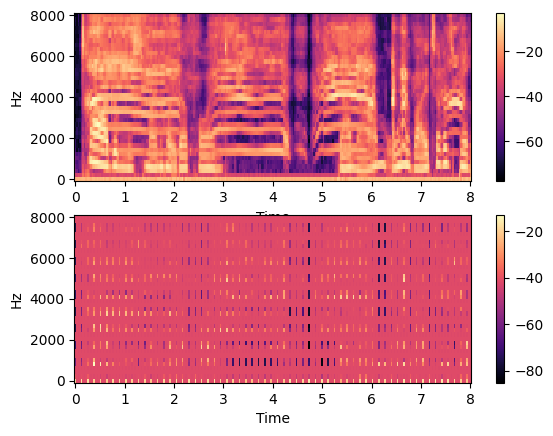

In [174]:
import librosa
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
librosa.display.specshow(featsEval.squeeze().numpy(), sr=16000, x_axis='time', y_axis='linear')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(y_feats.squeeze().numpy(), sr=16000, x_axis='time', y_axis='linear')
plt.colorbar()